<a href="https://colab.research.google.com/github/RahmanKhorramfar91/UAI_AI_Energy_Case_Studies/blob/main/Case%20Study%204%20-%20Capacity%20Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study 4 - Universal AI, AI and Sustainability: Energy**

## About the Case Study

Taking a step back from operational decisions in Case Study 3 is the planning phase for grid assets which is usually carried out by capacity expansion models (CEMs). These models determine the optimal location, sizing, and timing of major grid assets such as generators, storage, and transmission lines. Examples of CEMs include generation/transmission expansion problem (GEP and TEP), and their integrated model: generation and transmission expansion problem (GTEP).
This case study presents modeling and implementation for a simplified GTEP, and its extensions to evaluate the role of two new technologies, long-duration energy storage (LDES) and carbon capture and storage (CCS).

These problems are widely used as decision-support tools for major energy infrastructure projects that are usually multi-decadal investment decisions to strategic goals while ensuring affordability, reliability, and sustainability of the electric grid. Example of a strategic goal is the *energy transition* that is characterized by moving away from the current fossil-fuel-dominated grid to a decarbonized one. This transition requires detailed planning to find transition *pathways* that are roadmaps outlining the required investment and system operations in response to different technological, meteorological, policy-related, and socio-economic factors. Needless to say, finding these pathways is challenging, not least due to the uncertainty of the future that affects the parameters and all the modeling aspects.

Be began with the mathematical model and implementation of a stylized GTEP with the goal of providing a foundation for more complex models and showing how different modeling assumptions can impact the overall outcome. The case study concludes with questions...



**Overview of the content**:

1. [Getting Started](#getting_started)
2. [Generation and Transmission Expansion Problem](#GTEP)
3. [New Technologies](#tech)
4. [Case Study Questions](#questions)
5. [References and Further Reading](#references)

# **<font color='blue'>1. Getting Started </font>**  <a name="getting_started"></a>

Like previously, the supply and demand parameters for the GTEP will be based on the historical ISONE data available at [the GitHub repository](https://github.com/RahmanKhorramfar91/UAI_AI_Energy_Case_Studies).



In [ ]:
import numpy as np; # for scientific computing
import pandas as pd; # for data science
import matplotlib.pyplot as plt; # for plotting
from statsmodels.tsa.seasonal import seasonal_decompose; # for statistical models including forecasting
from statsmodels.tsa.stattools import adfuller;
from statsmodels.tsa.arima.model import ARIMA;
import xgboost as xgb; # for XGBoos technique
from xgboost import plot_importance, plot_tree;
import os; # for directory control
import zipfile; # to handle zip files
import time;
import networkx as nx;  # for plotting the network
import tensorflow as tf; # tensorflow
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import *;
from tensorflow.keras.callbacks import ModelCheckpoint;
from tensorflow.keras.losses import MeanSquaredError;
from tensorflow.keras.metrics import RootMeanSquaredError;
from tensorflow.keras.optimizers import Adam;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf; # for ACF and PACF plots used in ARIMA
np.random.seed(2025);

Install the [`pyoptinterface` package](https://metab0t.github.io/PyOptInterface/index.html).

In [ ]:
# install and fetch the pyoptinterface, an open-source Python library that provides a unified, high-performance interface
!pip install pyoptinterface[highs]
import pyoptinterface as poi;
from pyoptinterface import highs;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.4 MB/s eta 0:00:00


In [ ]:
# install the clustering package pyclustering
!pip install pyclustering;
from pyclustering.cluster.kmedoids import kmedoids;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=5476b3cf7880a634ec2b3c7cf9e52ae5ad946f03902c377b51c3e9f6fad01f30
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


Clone the GitHub repo and unzip the files.

In [ ]:
!git clone 'https://github.com/RahmanKhorramfar91/UAI_AI_Energy_Case_Studies.git';
zip_file_path = os.getcwd()+'/UAI_AI_Energy_Case_Studies/load_time_series_data_ISONE_2000-2023.zip';
extract_dir = os.getcwd()+'/load_time_series_data_ISONE_2000-2023';
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir);

Cloning into 'UAI_AI_Energy_Case_Studies'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 82 (delta 47), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 9.61 MiB | 8.67 MiB/s, done.
Resolving deltas: 100% (47/47), done.




# **<font color='blue'>2. Generation and Transmission Expansion Problem </font>**  <a name="GTEP"></a>

GTEPs are usually large-scale, often intractable optimization problems. Therefore, it is common to solve these problems at coarse spatio-temporal resolutions by reducing the number of nodes (locations) and planning periods.

## **Assumptions**
Here, we solve a GTEP under following assumptions:

- **Single-period**: Investment decisions are made in one period which can span multiple years. For example, if the planning horizon is 2050, all investments are assumed to occur between now and 2050  in one time block. In contrast, **multi-period** GTEP distributes investment decisions across several stages (e.g., every 5 years until 2050).

- **Deterministic parameters**: All parameters (demand, cost, etc.) for the target year are assumed to be known with certainty and represented as fixed values. Alternative approaches would be **stochastic programming** and **robust optimization**.

- **Coarse resolution**: The model is solved at a zonal level using a reduced set of weighted `representative days`, rather than at the bus level with full year chronology.

- **Centralized decision maker**:  Grid expansion decisions are made by a single entity with full authority and complete information. While real-world decisions depend on market structure, centralized models are still prevalent in deregulated markets due to their ease of modeling, computation, and interpretation.
- **Independent operations**: The electricity system is modeled in isolation without coupling to other energy vectors such as natural gas and transportation. In reality, these systems are interdependent
- **Green field**: Planning starts from scratch with no existing infrastructure. By contrast, a **brown-field** assumption considers the existing generators, storage, and transmission lines.

- **Other**: The model excludes the distribution network and uses simplified technological and policy-related constraints. A high-fidelity GTEP may include UC decisions, land-use availability for renewables, environmental considerations, reserve requirements, contingency, and more.







## **<font color='black'>Sets, Parameters, Variables </font>**





**Sets**
- $\mathcal{N}$: nodes, by $n, m$
- $\mathcal{H}$: thermal generator types, indexed by $h$
- $\mathcal{V}$: renewable generator types, indexed by $r$
- $\mathcal{G}$: all generators, indexed by $g$
- $\mathcal{K}$: storage types, indexed by $k$
- $\mathcal{T}$: planning hours, indexed by $t$

**Parameters**
- $D_{nt}$: demand [MW]       
- $c^{\text{line}}_{nm}$: CAPEX for lines (\$/MW)
- $c^{\text{th}}_h$: annualized CAPEX for thermal (\$/MW)
- $c^{\text{vre}}_r$: annualized CAPEX for VRE (\$/MW)
- $c^{\text{en}}_k$: annualized CAPEX for storage energy rating (\$/MWh)
- $c^{\text{pow}}_k$: annualized  CAPEX for storage power rating (\$/MW)
- $c_h$: marginal generation cost for thermal units [\$/MWh]
- $c^{\text{VoLL}}$: value of lost load [\$/MWh]
- $c^{\text{curt}}$: renewable curtailment penalty [\$/MWh]
- $w_t$: time period weight
- $\rho_{rnt}\in [0,1]$: capacity factor for renewables [MW]
- $\gamma^{\text{ch}}, \gamma^{\text{dis}}$: charge/discharge efficiency
- $U^{\text{strCap}}$: upper-bound for total storage capacity

**Variables**
- $z_{nm} \in \mathbb{R}^+$: installed line capacity between nodes, [MW]
- $x^{\text{th}}_{hn} \in \mathbb{R^+} \text{or } \mathbb{Z}^+ $: installed capacity for thermal types
- $x^{\text{vre}}_{rn} \in \mathbb{R^+}$: installed capacity for VRE types
- $y^{\text{en}}_{kn}, y^{\text{pow}}_{kn} \in \mathbb{R^+}$: installed storage level, and charge/discharge capacity [MWh] and [MW]
- $p^h_{hnt}, p^r_{rnt}\in \mathbb{R}^+$: power generation from thermal and VRE [MW]
- $f_{nm t}\in \mathbb{R}$: flow, [MW]
- $a_{nt}, R_{rnt} \in \mathbb{R}^+$: lost load and renewable curtailment [MW]
- $s^{\text{lev}}_{knt} \in \mathbb{R}^+$: storage level, [MWh]
- $s^{\text{ch}}_{knt}, s^{\text{dis}}_{knt} \in \mathbb{R}^+$: storage charge/discharge, [MW]

## **<font color='black'> Mathematical Model </font>**





**<font color='blue'>Objective Function </font>**   

Investment costs including transmission lines, thermal/VRE generators, and battery storage +

Operational cost, including marginal generation for thermal units, renewable curtailment, and lost load


\begin{align*}
    \min & \sum_{n,m \in \mathcal{N}, n>m} c^{\text{line}}_{nm} z_{nm}+ \sum_{h\in \mathcal{H}, n\in \mathcal{N}} c^{\text{th}}_{h} x^{\text{th}}_{hn}+\sum_{r\in \mathcal{V}, n\in \mathcal{N}} c^{\text{vre}}_{r} x^{\text{vre}}_{rn}+\sum_{k\in \mathcal{K} n\in \mathcal{N}} (c^{\text{en}}_{k} y^{\text{en}}_{kn} + c^{\text{pow}}_{k} y^{\text{pow}}_{kn})\\
    \Large + & \sum_{t\in \mathcal{T}, n\in \mathcal{N}} \left[w_t\sum_{h\in \mathcal{H}} c_h p^h_{hnt} + \sum_{r\in \mathcal{V}} c^{\text{curt}}R_{rnt} + c^{\text{VoLL}} a_{nt} \right]
\end{align*}

**<font color='blue'>Constraints </font>**   

Power balance
\begin{align*}
    & \sum_{h\in \mathcal{H}} p^h_{hnt} + \sum_{r\in \mathcal{V}} p^r_{rnt}+\sum_{m\in \mathcal{N}/n}f_{nm t}+\sum_{k\in \mathcal{K}}(s^{\text{dis}}_{knt}-s^{\text{ch}}_{knt})+a_{nt}=D_{nt} & n\in \mathcal{N}, t\in \mathcal{T}
\end{align*}



generation limit

\begin{align*}
    & p^h_{hnt}\leq x^{\text{th}}_{hn} & h\in \mathcal{H}, n\in \mathcal{N}, t\in \mathcal{T}\\
    & p^r_{rnt}+R_{rnt} = \rho_{rnt} x^{\text{vre}}_{rn} & r\in \mathcal{V}, n\in \mathcal{N}, t\in \mathcal{T}\\
\end{align*}


flow limit

\begin{align*}
    &-U_\ell z_\ell \leq f_{\ell t}\leq U_\ell z_\ell & \ell \in \mathcal{L}, t\in \mathcal{T}\\
\end{align*}

storage
    \begin{align}
    &s^{\text{lev}}_{knt} = s^{\text{lev}}_{kn,t-1}+ \gamma^{\text{ch}} s^{\text{ch}}_{knt} - \frac{s^{\text{dis}}_{knt}}{\gamma^{\text{dis}}}, \qquad s^{\text{lev}}_{kn0}=0&k\in \mathcal{K}, n\in \mathcal{N}, t\in \mathcal{T}\backslash t_0\\
    &s^{\text{lev}}_{knt}\leq y^{\text{en}}_{kn}, \quad s^{\text{ch}}_{knt}\leq y^{\text{pow}}_{kn} ,\quad s^{\text{ch}}_{knt}\leq  y^{\text{pow}}_{kn}& k\in \mathcal{K}, n\in \mathcal{N}, t\in \mathcal{T}\\
    & \sum_{k\in \mathcal{K}, n \in \mathcal{N}} y^{\text{en}}_{kn} \leq U^{\text{strCap}}
\end{align}

Define the problem configuration:

In [ ]:
Setting = {
    'num_nodes': 6,
    'num_rep_days': 5,
    'num_thermal_types': 2,
    'num_solar_types': 1,
    'num_wind_types': 1,
    'num_storage_types': 1,
    'annual_demand_growth_rate': 0.01,
    'sample_year': 2023
    };

define a data class to store all parameters:

In [ ]:
np.random.seed(2025);
class Data_Collector():
  def __init__(self, Setting):
  # declare parameters
    self.nD = Setting['num_rep_days'];
    self.nN = Setting['num_nodes'];
    self.nT = self.nD*24;
    self.nH = Setting['num_thermal_types'];
    self.nSolar = Setting['num_solar_types'];
    self.nWind = Setting['num_wind_types'];
    self.nV = self.nSolar+self.nWind;
    self.nK = Setting['num_storage_types'];
    self.sample_year = Setting['sample_year'];
    self.annual_demand_growth_rate = Setting['annual_demand_growth_rate'];
    # declare sets
    self.N = range(self.nN);
    self.H = range(self.nH);
    self.V = range(self.nV);
    self.K = range(self.nK);
    self.T = range(self.nT);

    # declare parameters
    self.demand=None;
    self.CFs=None;
    self.hours_weights = None;
    self.C_line = None;
    self.C_th = None;
    self.C_vre = None;
    self.C_en = None;
    self.C_pow = None;
    self.C_h = None;
    self.C_VoLL = None;
    self.C_curt = None;
    self.store_eff_ch = None;
    self.store_eff_dis = None;


Define a function to get the representative days and their weights, and demand and supply parameters for the representative days.

In [ ]:
np.random.seed(2025);
def rep_weights_demand_supply(data):
  '''
  data: data class instance
  '''
  nD = data.nD; nN=data.nN; yr = data.sample_year;nSolar=data.nSolar; nWind=data.nWind;
  demand_growth = data.annual_demand_growth_rate;

  initial_medoids = np.random.randint(1, 365, size=data.nD);
  data = pd.read_csv(f'/content/load_time_series_data_ISONE_2000-2023/load_time_series_data/{yr}_ISONE_load.csv');
  selected_columns = ['gross_load_MW', 'temperature_C', 'global_horizontal_irradiance', '10m_wind_speed'];

  data_selected = data[selected_columns].iloc[:8760];
  hourly_data = data_selected.to_numpy();

  # reshape the hourly data into daily batches. Notice that the reshaped data has the form load1, temp1, irradiance1, wind 1, load 2, ...
  daily_hourly_3D = hourly_data.reshape(-1,24, hourly_data.shape[1]);

  daily_hourly_flattened = daily_hourly_3D.reshape(daily_hourly_3D.shape[0], -1);
  model = kmedoids(daily_hourly_flattened, initial_medoids, intermax=3);
  model.process();
  clusters = model.get_clusters();
  medoids = model.get_medoids();
  rep_hour_weights = np.zeros(nD*24);
  for d in range(nD):
    rep_hour_weights[d*24:(d+1)*24] = len(clusters[d]);

  demand = np.zeros((nD*24, nN));
  supp = np.zeros((nD*24, nN, nSolar+nWind));
  dist_factor = np.random.dirichlet(np.ones(nN), size=1);

  # at least 60% of nodes can have solar installed
  emp = np.random.randint(0,nN, size=round(0.4*nN));
  dist_factorS = np.random.dirichlet(np.ones(nN), size=1);
  dist_factorS[:,emp] = 0
  dist_factorS = dist_factorS/dist_factorS.sum();

  # at least 30% of node can have wind installed
  emp = np.random.randint(0,nN, size=round(0.7*nN));
  dist_factorW = np.random.dirichlet(np.ones(nN), size=1);
  dist_factorW[:,emp] = 0
  dist_factorW = dist_factorW/dist_factorW.sum();
  # print(dist_factorS, dist_factorW);
  for d in range(nD):
    demand[d*24:(d+1)*24,:] = ((1+demand_growth)**25)*(daily_hourly_3D[d, :, 0].reshape(-1,1)@dist_factor);


    for sl in range(nSolar):
      supp[d*24:(d+1)*24,:,sl] = daily_hourly_3D[d, :, 2].reshape(-1,1)@dist_factorS;
      supp[d*24:(d+1)*24,:,sl] = supp[d*24:(d+1)*24,:,sl]/supp[d*24:(d+1)*24,:,sl].max();

    for wl in range(nWind):
      supp[d*24:(d+1)*24,:,nSolar+wl] = daily_hourly_3D[d, :, 3].reshape(-1,1)@dist_factorW;
      supp[d*24:(d+1)*24,:,nSolar+wl] = supp[d*24:(d+1)*24,:,nSolar+wl]/supp[d*24:(d+1)*24,:,nSolar+wl].max();

  return medoids, rep_hour_weights, demand, supp;



Define model,  decision variables, objective function, and constraints.


In [ ]:
np.random.seed(2025);
def define_decision_variables(Model,data):
  # define a class to distinguish the variables from parameters
  class DV():
    z=[]; x_th=[]; x_vre=[]; y_en=[]; y_pow=[];
    p_th=[]; p_vre=[]; f=[]; a=[];curt=[]; s_lev=[]; s_ch=[]; s_dis=[];
    total_cost = [];
    inv_cost_line=[]; inv_cost_th=[]; inv_cost_vre=[]; inv_cost_str=[];
    gen_cost=[]; lost_load_cost=[]; curtailment_cost=[];
  N = data.N; H = data.H; V = data.V; K = data.K; T = data.T;

  DV.z = Model.add_variables(N,N, lb=0, domain=poi.VariableDomain.Continuous);
  DV.x_th = Model.add_variables(H,N, lb=0, domain=poi.VariableDomain.Continuous);
  DV.x_vre = Model.add_variables(V,N, lb=0, domain=poi.VariableDomain.Continuous);
  DV.y_en = Model.add_variables(K,N, lb=0, domain=poi.VariableDomain.Continuous);
  DV.y_pow = Model.add_variables(K,N, lb=0, domain=poi.VariableDomain.Continuous);
  DV.p_th = Model.add_variables(H,N,T, lb=0, domain=poi.VariableDomain.Continuous);
  DV.p_vre = Model.add_variables(V,N,T, lb=0, domain=poi.VariableDomain.Continuous);
  DV.f = Model.add_variables(N,N,T, domain=poi.VariableDomain.Continuous); # free variable
  DV.a = Model.add_variables(N,T, lb=0, domain=poi.VariableDomain.Continuous);
  DV.curt = Model.add_variables(V, N,T, lb=0, domain=poi.VariableDomain.Continuous);
  DV.s_lev = Model.add_variables(K,N,T, lb=0, domain=poi.VariableDomain.Continuous);
  DV.s_ch = Model.add_variables(K,N,T, lb=0, domain=poi.VariableDomain.Continuous);
  DV.s_dis = Model.add_variables(K,N,T, lb=0, domain=poi.VariableDomain.Continuous);

  DV.total_cost = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);
  DV.inv_cost_line = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);
  DV.inv_cost_th = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);
  DV.inv_cost_vre = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);
  DV.inv_cost_str = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);
  DV.gen_cost = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);
  DV.lost_load_cost = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);
  DV.curtailment_cost = Model.add_variable(lb=0, domain=poi.VariableDomain.Continuous);

  return DV;

def define_objective_function(Model, DV, data):
  C_line = data.C_line; C_th = data.C_th; C_vre = data.C_vre; C_en = data.C_en; C_pow = data.C_pow; C_h = data.C_h; C_VoLL = data.C_VoLL; C_curt = data.C_curt;
  hours_weights = data.hours_weights; demand = data.demand; CFs = data.CFs;
  N = data.N; H = data.H; V = data.V; K = data.K; T = data.T;

  Model.add_linear_constraint(DV.inv_cost_line-poi.quicksum(C_line[n,m]*DV.z[n,m] for n in N for m in range(n)),  poi.Eq, 0);
  Model.add_linear_constraint(DV.inv_cost_th-poi.quicksum(C_th[h]*DV.x_th[h,n] for h in H for n in N), poi.Eq, 0);
  Model.add_linear_constraint(DV.inv_cost_vre-poi.quicksum(C_vre[r]*DV.x_vre[r,n] for r in V for n in N), poi.Eq, 0);
  Model.add_linear_constraint(DV.inv_cost_str-poi.quicksum(C_en[k]*DV.y_en[k,n] + C_pow[k]*DV.y_pow[k,n] for k in K for n in N), poi.Eq, 0);

  Model.add_linear_constraint(DV.gen_cost-poi.quicksum(hours_weights[t]*poi.quicksum(C_h[h]*DV.p_th[h,n,t] for h in H) for t in T for n in N), poi.Eq, 0);
  Model.add_linear_constraint(DV.lost_load_cost-poi.quicksum(hours_weights[t]*C_VoLL*DV.a[n,t] for n in N for t in T), poi.Eq, 0);
  Model.add_linear_constraint(DV.curtailment_cost-poi.quicksum(hours_weights[t]*C_curt*DV.curt[r, n,t] for r in V for n in N for t in T), poi.Eq, 0);

  Model.add_linear_constraint(DV.total_cost-DV.inv_cost_line-DV.inv_cost_th-DV.inv_cost_vre-DV.inv_cost_str-DV.gen_cost-DV.lost_load_cost-DV.curtailment_cost, poi.Eq, 0);

  Model.set_objective(DV.total_cost, poi.ObjectiveSense.Minimize);

def add_constraints(Model, DV, data):
  N = data.N; H = data.H; V = data.V; K = data.K; T = data.T;
  demand = data.demand; CFs = data.CFs; store_eff_ch = data.store_eff_ch; store_eff_dis = data.store_eff_dis;
  # balance equation
  for n in N:
    for t in T:
      Model.add_linear_constraint(poi.quicksum(DV.p_th[h,n,t] for h in H) +
                                  poi.quicksum(DV.p_vre[r,n,t] for r in V)+
                                  poi.quicksum(DV.f[n,m,t] for m in N if m!=n)+
                                  poi.quicksum(DV.s_dis[k,n,t]-DV.s_ch[k,n,t] for k in K)+
                                  DV.a[n,t], poi.Eq, demand[t,n]);
  # generation limit
  for n in N:
    for t in T:
      for h in H:
        Model.add_linear_constraint(DV.p_th[h,n,t]-DV.x_th[h,n], poi.Leq,  0);
      for r in V:
        Model.add_linear_constraint(DV.p_vre[r,n,t]+DV.curt[r,n,t]- CFs[t,n,r]*DV.x_vre[r, n], poi.Eq, 0);

  # flow limit
  for n in N:
    for m in range(n):
      for t in T:
        Model.add_linear_constraint(DV.f[n,m,t]-DV.z[n,m], poi.Leq, 0);
        Model.add_linear_constraint(DV.f[n,m,t]+DV.z[n,m], poi.Geq, 0);
        Model.add_linear_constraint(DV.f[n,m,t]+DV.f[m,n,t], poi.Eq, 0);
      Model.add_linear_constraint(DV.z[n,m]-DV.z[m,n], poi.Eq, 0);

  # storage
  for k in K:
    for n in N:
      for t in T:
        if t==0:
          Model.add_linear_constraint(DV.s_lev[k,n,t]==0);
          continue;
        Model.add_linear_constraint(DV.s_lev[k,n,t]-DV.s_lev[k,n,t-1]-store_eff_ch[k]*DV.s_ch[k,n,t]+(1/store_eff_dis[k])*DV.s_dis[k,n,t], poi.Eq, 0);
        Model.add_linear_constraint(DV.s_lev[k,n,t]- DV.y_en[k,n], poi.Leq,0);
        Model.add_linear_constraint(DV.s_ch[k,n,t]- DV.y_pow[k,n], poi.Leq,0);
        Model.add_linear_constraint(DV.s_dis[k,n,t]- DV.y_pow[k,n], poi.Leq,0);
  # storage installment limit
  Model.add_linear_constraint(poi.quicksum(DV.y_pow[k,n] for k in K for n in N), poi.Leq, 0.5*np.max(demand.max()));

plotting functions:

In [ ]:
np.random.seed(2025);
def plot_bar_chart(Model, data):
  H = data.H; nSolar=data.nSolar; nWind=data.nWind; nN=data.nN; N = data.N; K = data.K;
  nH = data.nH; nV = data.nV; nK = data.nK;
  # create labels and colors for different types
  labels = [f'thermal {i+1}' for i in H]+ \
  [f'Solar {i+1}' for i in range(nSolar)]+\
  [f'Wind {i+1}' for i in range(nWind)]+ [f'Storage {i+1}' for i in K];
  # print(labels);

  #  colormaps objects
  thermal_cmap = plt.colormaps.get_cmap('copper'); # Greys for thermal (coal, gas, nuclear, etc).
  solar_cmap = plt.colormaps.get_cmap('Wistia'); # yellow spectrum for solar
  wind_cmap = plt.colormaps.get_cmap('summer'); # green and blue for wind
  storage_cmap = plt.colormaps.get_cmap('plasma'); # purplish for storage
  colors = [thermal_cmap(i/nH) for i in H] + [solar_cmap(i/nSolar) for i in range(nSolar)] +\
  [wind_cmap(i/nWind) for i in range(nWind)]+ [storage_cmap(i/nK) for i in K] ;

  new_gen = np.zeros((nN, nH+nV+nK));
  for n in N:
    for h in H:
      new_gen[n,h] = Model.get_value(DV.x_th[h,n]);
    for r in range(nSolar):
      new_gen[n,nH+r] = Model.get_value(DV.x_vre[r,n]);
    for r in range(nWind):
      new_gen[n,nH+nSolar+r] = Model.get_value(DV.x_vre[r+nSolar,n]);
    for k in K:
      new_gen[n,nH+nV+k] = Model.get_value(DV.y_pow[k,n]);

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4),
                        gridspec_kw={'width_ratios': [10],'height_ratios': [5],
                        'wspace': 0.1,'hspace': 0.1});

  bt = np.zeros(nN);
  for g in range(nH+nV+nK):
    ax.bar(N, new_gen[:, g], bottom=bt, width=0.7, color=colors[g], label=labels[g]);
    bt = bt + new_gen[:, g];
  ax.set_ylim(0, 1.1*max(new_gen.sum(axis=1)));
  ax.set_ylabel('Capacity (MW)', fontsize=12, fontweight='bold');
  ax.set_xlabel('Node', fontsize=12, fontweight='bold');
  ax.legend(ncol=2, bbox_to_anchor=(1, 1), prop={'size':8});

def visualize_new_line_capacity(Model, data):
  nN = data.nN; N = data.N;
  # Extract results for visualization
  line_cap = np.zeros((nN, nN))
  for n in N:
      for m in range(n):
          line_cap[n,m] = Model.get_value(DV.z[n,m]);
          line_cap[m,n] = line_cap[n,m];

  # Create the network
  G = nx.Graph();
  G.add_nodes_from(N);  # define nodes
  pos = nx.spring_layout(G); # node positions. Can be replaced by actual coordinates
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4),
                        gridspec_kw={'width_ratios': [10],'height_ratios': [5],
                        'wspace': 0.1,'hspace': 0.1}); # draw the network

  # Add lines
  edges=[];
  for n in N:
      for m in range(n):
          if line_cap[n, m] > 1: # add edge only if the new cap is substantial
              G.add_edge(n, m, capacity=round(line_cap[n, m]));
              edges.append((n, m, round(line_cap[n, m])));

  # Draw edges with thickness proportional to capacity
  edge_widths = [d['capacity']/1000 for (u, v, d) in G.edges(data=True)]; # line thickness proportional to capacity
  nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='xkcd:azul');

  # add edge labels
  nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'capacity'), font_color='xkcd:burgundy');

  # draw nodes and add labels
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='xkcd:desert', alpha=1);
  nx.draw_networkx_labels(G, pos, font_size=10, font_weight = 'bold');



**Initialize the GTEP model, polulate parameters, define the model, solve and post-process**

In [ ]:
np.random.seed(2025);
s_time = time.time();
# set the setting if it is different than the defualt
Setting['num_rep_days'] = 5;
Setting['num_nodes'] = 4;
Setting['num_thermal_types']= 2;
Setting['num_storage_types']= 1;

dt = Data_Collector(Setting);
rep_days, hours_weights, demand, CFs = rep_weights_demand_supply(dt);

dt.hours_weights = hours_weights;
dt.demand = demand;
dt.CFs = CFs;
dt.C_line = np.random.randint(20,25,size=(dt.nN,dt.nN)); # CAPEX for lines (\$/MW)
dt.C_line = np.round((dt.C_line + dt.C_line.T)/2); # to make it symmetric
dt.C_th = np.random.randint(300, 400,size=dt.nH); # annualized CAPEX for thermal (\$/MW)
dt.C_vre = np.random.randint(300, 2000,size=dt.nV); # annualized CAPEX for VRE (\$/MW)
dt.C_en = np.random.randint(900, 1000,size=dt.nK); # annualized CAPEX for storage energy rating (\$/MWh)
dt.C_pow = np.random.randint(150, 200,size=dt.nK); # annualized  CAPEX for storage power rating (\$/MW)
dt.C_h = np.random.randint(2, 3, size=dt.nH); # marginal generation cost for thermal units [\$/MWh]
dt.C_VoLL = 1e4; # value of lost load [\$/MWh]
dt.C_curt = 1; # renewable curtailment penalty [\$/MWh]
dt.store_eff_ch, dt.store_eff_dis = np.random.uniform(0.8, 0.9, size=dt.nK), np.random.uniform(0.8, 0.9, size=dt.nK); # charge/discharge efficiency


# MODEL INSTANCE
Model = highs.Model();
DV = define_decision_variables(Model, dt);
define_objective_function(Model, DV, dt);
add_constraints(Model, DV, dt);

### SOLVE THE MODEL
Model.set_model_attribute(poi.ModelAttribute.Silent, 0);
Model.optimize();
### POST-PROCESSING
print(f'total cost: {round(Model.get_value(DV.total_cost))}, elapsed time: {round(time.time()-s_time)}s');\
print(f'\nline inv: {round(Model.get_value(DV.inv_cost_line))}, \
thermal inv: {round(Model.get_value(DV.inv_cost_th))}, \
VRE inv:{round(Model.get_value(DV.inv_cost_vre))}, storage: {round(Model.get_value(DV.inv_cost_str))}');

print(f'generation cost (thermal): {round(Model.get_value(DV.gen_cost))} \
lost load cost: {round(Model.get_value(DV.lost_load_cost))}, \
curtailment: {round(Model.get_value(DV.curtailment_cost))}');

gen_th=np.zeros(dt.nH, dtype=int); gen_solar=np.zeros(dt.nSolar, dtype=int); gen_wind=np.zeros(dt.nWind, dtype=int);

for n in dt.N:
  for t in dt.T:
    for h in dt.H:
      gen_th[h] += Model.get_value(DV.p_th[h,n,t]);
    for r in range(dt.nSolar):
      gen_solar[r] += Model.get_value(DV.p_vre[r,n,t]);
    for r in range(dt.nWind):
      gen_wind[r] += Model.get_value(DV.p_vre[r+dt.nSolar,n,t]);

print(f'\n thermal: {gen_th}, solar: {gen_solar}, wind: {gen_wind}, total gen: {gen_th.sum()+gen_solar.sum()+gen_wind.sum()}, total load: {round(np.sum(demand.sum()))}');


total cost: 75725676, elapsed time: 3s

line inv: 432400, thermal inv: 2931796, VRE inv:35646600, storage: 2215118
generation cost (thermal): 26433410 lost load cost: 0, curtailment: 8066352

 thermal: [134987      0], solar: [93962], wind: [1836295], total gen: 2065244, total load: 1979028


Analyze the outcome

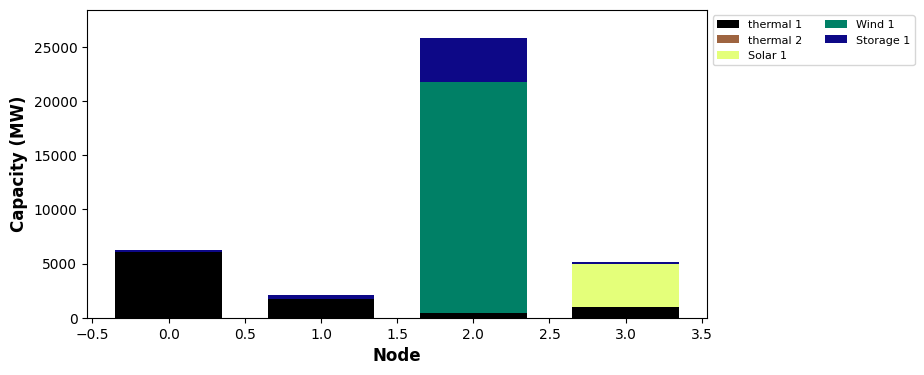

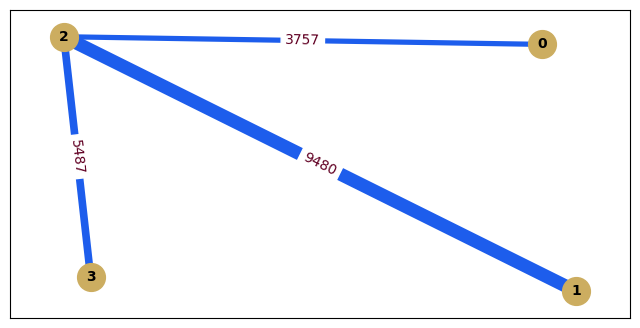

In [ ]:
plot_bar_chart(Model, dt);
visualize_new_line_capacity(Model, dt);

<br><br><br>

# **<font color='blue'>3. New Technologies </font>**  <a name="tech"></a>

## **Long-Duration Energy Storage (LDES)**

duration of storage exceeds 10 hours, whereas the existing lithium-ion batteries have a duration of 2-4 hours.

In [ ]:
np.random.seed(2025);
s_time = time.time();
# set the setting if it is different than the defualt
Setting['num_rep_days'] = 5;
Setting['num_nodes'] = 4;
Setting['num_thermal_types']= 2;
Setting['num_storage_types']= 2;

dt = Data_Collector(Setting);
rep_days, hours_weights, demand, CFs = rep_weights_demand_supply(dt);

dt.hours_weights = hours_weights;
dt.demand = demand;
dt.CFs = CFs;
dt.C_line = np.random.randint(20,25,size=(dt.nN,dt.nN)); # CAPEX for lines (\$/MW)
dt.C_line = np.round((dt.C_line + dt.C_line.T)/2); # to make it symmetric
dt.C_th = np.random.randint(300, 400,size=dt.nH); # annualized CAPEX for thermal (\$/MW)
dt.C_vre = np.random.randint(300, 2000,size=dt.nV); # annualized CAPEX for VRE (\$/MW)
dt.C_en = np.random.randint(900, 1000,size=dt.nK); # annualized CAPEX for storage energy rating (\$/MWh)
dt.C_pow = np.random.randint(150, 200,size=dt.nK); # annualized  CAPEX for storage power rating (\$/MW)
dt.C_h = np.random.randint(2, 3, size=dt.nH); # marginal generation cost for thermal units [\$/MWh]
dt.C_VoLL = 1e4; # value of lost load [\$/MWh]
dt.C_curt = 1; # renewable curtailment penalty [\$/MWh]
dt.store_eff_ch, dt.store_eff_dis = np.random.uniform(0.9, 1, size=dt.nK), np.random.uniform(0.9, 1, size=dt.nK); # charge/discharge efficiency

# *** NEW PARAMETER
storage_durations = [4, 12]; # hours

# MODEL INSTANCE
Model = highs.Model();
DV = define_decision_variables(Model, dt);
define_objective_function(Model, DV, dt);
add_constraints(Model, DV, dt);

# NEW CONSTRAINTS
# add new constraints to consider the storage duration
for k in range(dt.nK):
  for n in dt.N:
    Model.add_linear_constraint(DV.y_en[k,n]-storage_durations[k]*DV.y_pow[k,n], poi.Leq, 0);

### SOLVE THE MODEL
Model.set_model_attribute(poi.ModelAttribute.Silent, 0);
Model.optimize();
### POST-PROCESSING
print(f'total cost: {round(Model.get_value(DV.total_cost))}, elapsed time: {round(time.time()-s_time)}s');\
print(f'\nline inv: {round(Model.get_value(DV.inv_cost_line))}, \
thermal inv: {round(Model.get_value(DV.inv_cost_th))}, \
VRE inv:{round(Model.get_value(DV.inv_cost_vre))}, storage: {round(Model.get_value(DV.inv_cost_str))}');

print(f'generation cost (thermal): {round(Model.get_value(DV.gen_cost))} \
lost load cost: {round(Model.get_value(DV.lost_load_cost))}, \
curtailment: {round(Model.get_value(DV.curtailment_cost))}');

gen_th=np.zeros(dt.nH, dtype=int); gen_solar=np.zeros(dt.nSolar, dtype=int); gen_wind=np.zeros(dt.nWind, dtype=int);

for n in dt.N:
  for t in dt.T:
    for h in dt.H:
      gen_th[h] += Model.get_value(DV.p_th[h,n,t]);
    for r in range(dt.nSolar):
      gen_solar[r] += Model.get_value(DV.p_vre[r,n,t]);
    for r in range(dt.nWind):
      gen_wind[r] += Model.get_value(DV.p_vre[r+dt.nSolar,n,t]);

print(f'\n thermal: {gen_th}, solar: {gen_solar}, wind: {gen_wind}, total gen: {gen_th.sum()+gen_solar.sum()+gen_wind.sum()}, total load: {round(np.sum(demand.sum()))}');



total cost: 78583369, elapsed time: 6s

line inv: 428431, thermal inv: 2525700, VRE inv:34800940, storage: 7459841
generation cost (thermal): 25575039 lost load cost: 0, curtailment: 7793418

 thermal: [130094      0], solar: [103684], wind: [1773094], total gen: 2006872, total load: 1979028


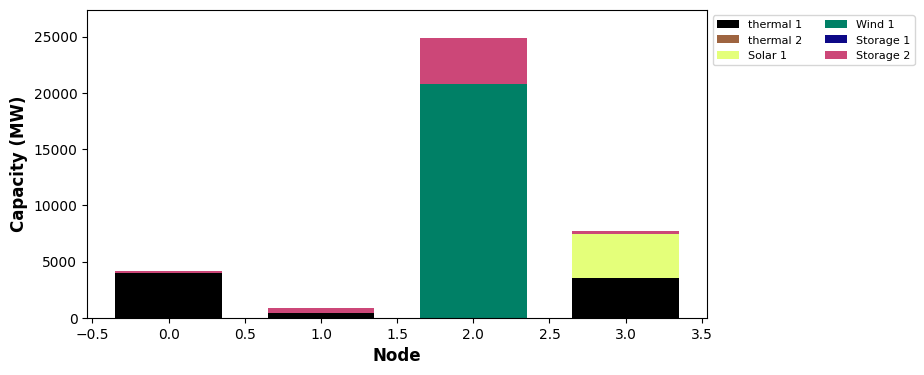

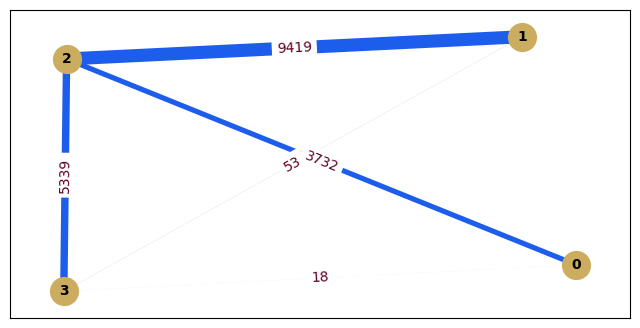

In [ ]:
plot_bar_chart(Model, dt);
visualize_new_line_capacity(Model, dt);

<br><br>

## **Carbon Capture and Storage (CCS)**

In [ ]:
np.random.seed(2025);
s_time = time.time();
# set the setting if it is different than the defualt
Setting['num_rep_days'] = 5;
Setting['num_nodes'] = 4;
Setting['num_thermal_types']= 2;
Setting['num_storage_types']= 2;

dt = Data_Collector(Setting);
rep_days, hours_weights, demand, CFs = rep_weights_demand_supply(dt);

dt.hours_weights = hours_weights;
dt.demand = demand;
dt.CFs = CFs;
dt.C_line = np.random.randint(20,25,size=(dt.nN,dt.nN)); # CAPEX for lines (\$/MW)
dt.C_line = np.round((dt.C_line + dt.C_line.T)/2); # to make it symmetric
dt.C_th = np.random.randint(300, 400,size=dt.nH); # annualized CAPEX for thermal (\$/MW)
dt.C_vre = np.random.randint(300, 2000,size=dt.nV); # annualized CAPEX for VRE (\$/MW)
dt.C_en = np.random.randint(900, 1000,size=dt.nK); # annualized CAPEX for storage energy rating (\$/MWh)
dt.C_pow = np.random.randint(150, 200,size=dt.nK); # annualized  CAPEX for storage power rating (\$/MW)
dt.C_h = np.random.randint(2, 3, size=dt.nH); # marginal generation cost for thermal units [\$/MWh]
dt.C_VoLL = 1e4; # value of lost load [\$/MWh]
dt.C_curt = 1; # renewable curtailment penalty [\$/MWh]
dt.store_eff_ch, dt.store_eff_dis = np.random.uniform(0.9, 1, size=dt.nK), np.random.uniform(0.9, 1, size=dt.nK); # charge/discharge efficiency

# *** NEW PARAMETER
storage_durations = [4, 12]; # hours
emission_per_MW = [500, 50]; # kg per MWh. Thermal plants: first one is a conventional (e.g., CCGT), second with CCS (CCGT-CCS) that captures most of the emissions
# carbon_penalty = 0.5; # dollar per kg of CO2 ($50 per tonne) [if carbon tax considered]

# MODEL INSTANCE
Model = highs.Model();
DV = define_decision_variables(Model, dt);
define_objective_function(Model, DV, dt);
add_constraints(Model, DV, dt);

# NEW CONSTRAINTS
# add new constraints to consider the storage duration
for k in range(dt.nK):
  for n in dt.N:
    Model.add_linear_constraint(DV.y_en[k,n]-storage_durations[k]*DV.y_pow[k,n], poi.Leq, 0);

# emissions constraint
total_possile_emissions = emission_per_MW[0]*np.sum(demand.sum());
Model.add_linear_constraint(poi.quicksum(emission_per_MW[h]*DV.p_th[h,n,t] for h in dt.H for n in dt.N for t in dt.T), poi.Leq, 0.02*total_possile_emissions);

### SOLVE THE MODEL
Model.set_model_attribute(poi.ModelAttribute.Silent, 0);
Model.optimize();
### POST-PROCESSING
print(f'total cost: {round(Model.get_value(DV.total_cost))}, elapsed time: {round(time.time()-s_time)}s');\
print(f'\nline inv: {round(Model.get_value(DV.inv_cost_line))}, \
thermal inv: {round(Model.get_value(DV.inv_cost_th))}, \
VRE inv:{round(Model.get_value(DV.inv_cost_vre))}, storage: {round(Model.get_value(DV.inv_cost_str))}');

print(f'generation cost (thermal): {round(Model.get_value(DV.gen_cost))} \
lost load cost: {round(Model.get_value(DV.lost_load_cost))}, \
curtailment: {round(Model.get_value(DV.curtailment_cost))}');

gen_th=np.zeros(dt.nH, dtype=int); gen_solar=np.zeros(dt.nSolar, dtype=int); gen_wind=np.zeros(dt.nWind, dtype=int);

for n in dt.N:
  for t in dt.T:
    for h in dt.H:
      gen_th[h] += Model.get_value(DV.p_th[h,n,t]);
    for r in range(dt.nSolar):
      gen_solar[r] += Model.get_value(DV.p_vre[r,n,t]);
    for r in range(dt.nWind):
      gen_wind[r] += Model.get_value(DV.p_vre[r+dt.nSolar,n,t]);

print(f'\n thermal: {gen_th}, solar: {gen_solar}, wind: {gen_wind}, total gen: {gen_th.sum()+gen_solar.sum()+gen_wind.sum()}, total load: {round(np.sum(demand.sum()))}');


total cost: 78733866, elapsed time: 7s

line inv: 428280, thermal inv: 2524303, VRE inv:34801931, storage: 10238221
generation cost (thermal): 23782818 lost load cost: 0, curtailment: 6958312

 thermal: [30742 88193], solar: [98763], wind: [1789152], total gen: 2006850, total load: 1979028


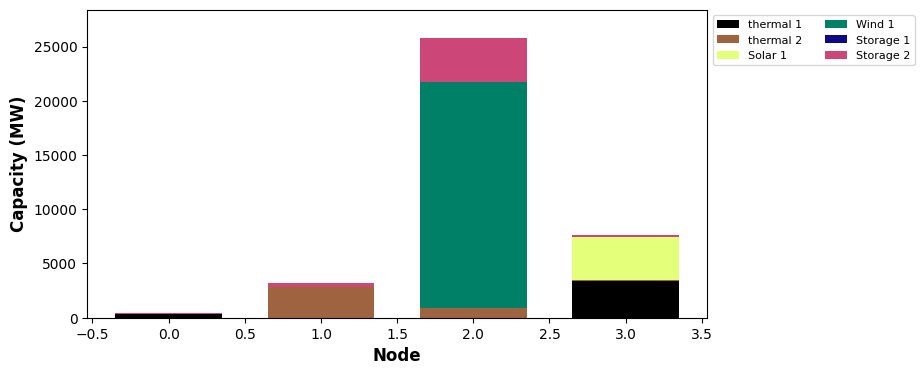

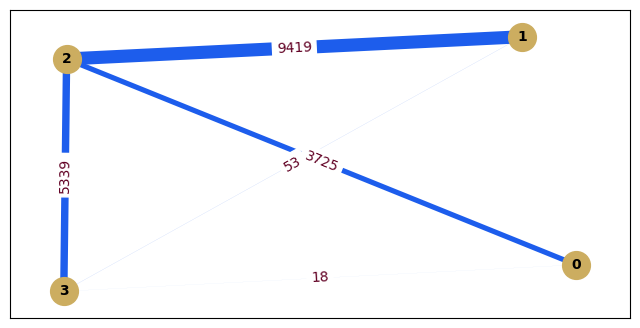

In [ ]:
plot_bar_chart(Model, dt);
visualize_new_line_capacity(Model, dt);


# **<font color='blue'>4. Case Study Questions </font>** <a name="questions"></a>

**<font color='red'> Questions </font>**
1. Consider a projection of load for 2050, either from the assignment of Case Study 1 or obtained by an approach presented above. Add ramping and unit commitment decisions and compare the outcomes with the GTEPs implemented here in terms of cost components, the share of thermal generation, and transmission line placement.

2. Consider a GTEP with $N$ nodes, $L$ lines, $P$ periods(e.g., every 5 years), and $S$ scenarios in which the investment decisions about thermal generators and candidate lines are integer and binary, respectively. Assume that the resulting mixed-integer program is intractable even for high-computing machines. How would you approach to solve this problem, either exactly or approximately? Propose at least two approaches and elaborate on your answer.

<br>
<br>
<br>




# **<font color='blue'>5. References and Further Reading </font>** <a name="references"></a>


- Conejo, A. J., Baringo, L., Kazempour, S. J., & Siddiqui, A. S. (2016). Investment in electricity generation and transmission. ([link](https://link.springer.com/book/10.1007/978-3-319-29501-5))
- Sun, X. A., & Conejo, A. J. (2021). Robust optimization in electric energy systems (Vol. 313). Cham: Springer.([link](https://link.springer.com/book/10.1007/978-3-030-85128-6))
- Koltsaklis, N. E., & Dagoumas, A. S. (2018). State-of-the-art generation expansion planning: A review. Applied energy, 230, 563-589. ([link](https://www.sciencedirect.com/science/article/pii/S0306261918312583?casa_token=4mOJwD3ZvRAAAAAA:nLxeoE76zLAzzTq8b_XglZDchlIrEoxYx5e2cLUm0T0e0e6o5JX8ISWkD_RmZ9npAGRS4HkDOg))
- Teichgraeber, H., & Brandt, A. R. (2022). Time-series aggregation for the optimization of energy systems: Goals, challenges, approaches, and opportunities. Renewable and Sustainable Energy Reviews, 157, 111984. ([link](https://www.sciencedirect.com/science/article/pii/S1364032121012478?casa_token=fj4drRB6RgsAAAAA:Z5Q2D3403Qp4t9JHIB7EuhShwIMvZpNbm2AGR9O0hMP9VW0nNn4eMg9qrbPCJwOteWKr15kq9g))


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

